### Importing packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Loading Dataset

In [2]:
true_path = "/Users/irray/Desktop/Projects/Fake News Classifier/dataset/True.csv"
fake_path = "/Users/irray/Desktop/Projects/Fake News Classifier/dataset/Fake.csv"

df_true = pd.read_csv(true_path)
df_fake = pd.read_csv(fake_path)

In [3]:
def detect_text_col(df):
    candidates = ["text", "content", "article", "title"]
    for c in candidates:
        if c in df.columns:
            return c
    return df.columns[0] 

In [4]:
tc_true = detect_text_col(df_true)
tc_fake = detect_text_col(df_fake)

df_true = df_true.rename(columns={tc_true: "text"})[["text"]].copy()
df_fake = df_fake.rename(columns={tc_fake: "text"})[["text"]].copy()

df_true["label"] = 0  
df_fake["label"] = 1  

df = pd.concat([df_true, df_fake], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
print("Dataset shape:", df.shape)

Dataset shape: (44898, 2)


### Train-Test Split

In [ ]:
X = df["text"].astype(str)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### TF-IDF Vectorizer

In [6]:
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Training Model using Logistic Regression

In [7]:
model = LogisticRegression(max_iter=200, solver="saga", n_jobs=-1, verbose=1)
model.fit(X_train_tfidf, y_train)

log_reg = model

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Epoch 1, change: 1
Epoch 2, change: 0.11233164
Epoch 3, change: 0.031587835
Epoch 4, change: 0.019987893
Epoch 5, change: 0.0085563934
Epoch 6, change: 0.0050235578
Epoch 7, change: 0.0080160652
Epoch 8, change: 0.0044088362
Epoch 9, change: 0.0022267839
Epoch 10, change: 0.0021943125
Epoch 11, change: 0.0006306467
Epoch 12, change: 0.00075348384
Epoch 13, change: 0.0011669982
Epoch 14, change: 0.00048975387
Epoch 15, change: 0.00015824458
convergence after 16 epochs took 1 seconds


### Evaluation

In [8]:
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

print("Final Test Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["True", "Fake"]))

Final Test Accuracy: 0.9881959910913141

Classification Report:
               precision    recall  f1-score   support

        True       0.99      0.99      0.99      4284
        Fake       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



### Confusion Matrix

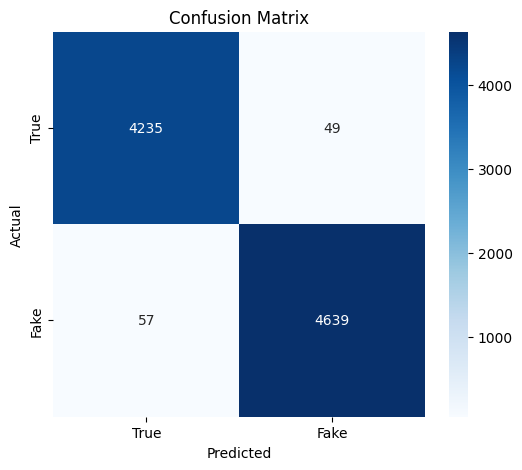

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["True","Fake"], yticklabels=["True","Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Accuracy Visualization

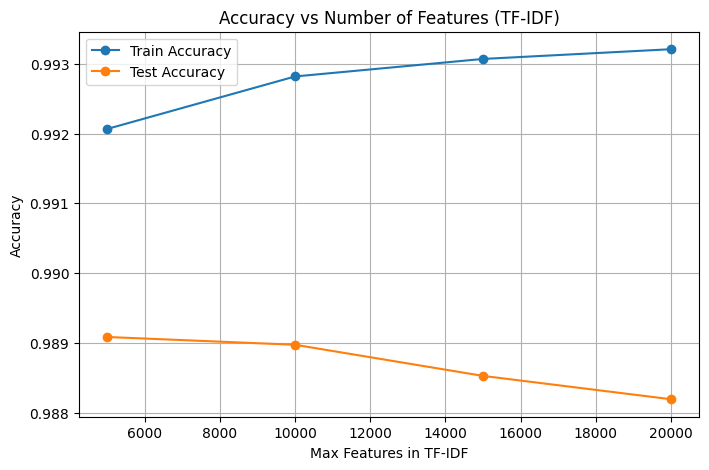

In [10]:
train_acc = []
test_acc = []
features = [5000, 10000, 15000, 20000]

for f in features:
    vect = TfidfVectorizer(max_features=f, ngram_range=(1,2), stop_words="english")
    X_train_f = vect.fit_transform(X_train)
    X_test_f = vect.transform(X_test)
    clf = LogisticRegression(max_iter=200, solver="saga", n_jobs=-1)
    clf.fit(X_train_f, y_train)
    train_acc.append(accuracy_score(y_train, clf.predict(X_train_f)))
    test_acc.append(accuracy_score(y_test, clf.predict(X_test_f)))

plt.figure(figsize=(8,5))
plt.plot(features, train_acc, marker="o", label="Train Accuracy")
plt.plot(features, test_acc, marker="o", label="Test Accuracy")
plt.title("Accuracy vs Number of Features (TF-IDF)")
plt.xlabel("Max Features in TF-IDF")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Saving Model + Vectorization for WebApp

In [ ]:
os.makedirs("../models", exist_ok=True)  

with open("../models/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("../models/log_reg.pkl", "wb") as f:
    pickle.dump(log_reg, f)

print("✅ Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!


In [12]:
# Testing
sample_text = df[df['label'] == 0]['text'].iloc[0]  
sample_vec = vectorizer.transform([sample_text])
print("Prediction:", model.predict(sample_vec))          
print("Probability:", model.predict_proba(sample_vec))   

Prediction: [0]
Probability: [[0.93927027 0.06072973]]
